# Tutorial on TorchPCA

This script demonstrates a fast Principal Component Analysis (PCA) implementation using PyTorch, optimized for GPU compatibility. It processes genotype data from VCF format, loads population labels, applies PCA, and visualizes the results using a scatter plot.

In [1]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

dir = os.path.abspath('../')
if not dir in sys.path: sys.path.append(dir)

from snputils.snp.io.read.vcf import VCFReader
from snputils.phenotype.io.read import MultiPhenTabularReader
from snputils.processing import TorchPCA

### 1. Load Genotype Data

Reads in a VCF file, extracts genotype data, and confirms data shapes and structure.

In [2]:
# Load genotype data using VCFReader
reader = VCFReader('../data/vcf/subset.vcf')
snpobj = reader.read(sum_strands=False)

# Extract genotype call data (GT) and display shape and data type
gt = snpobj.calldata_gt
print("Genotype data shape:", gt.shape)
print("Genotype data type:", gt.dtype)

# Retrieve sample names and validate uniqueness of each
samples = snpobj.samples
print("Samples:", samples)

# Remove common prefixes from sample names and verify uniqueness
samples_ = [s.split('_')[-1] for s in samples]
assert len(samples_) == len(set(samples_)), "Sample names are not unique."

Genotype data shape: (993881, 4, 2)
Genotype data type: int8
Samples: ['HG00096' 'HG00097' 'HG00099' 'HG00100']


### 2. Load Population Labels

Loads phenotype data, extracts sample labels, and matches each sample with its population label.

In [3]:
# Load phenotype data from tabular file and extract population labels
phen_reader = MultiPhenTabularReader('../data/samples_pops.tsv')
phenobj = phen_reader.read(phen_names=['population'], samples_idx=1)

# Create a dictionary mapping samples to population labels
pop_samples = phenobj.phen_df['samples'].to_list()
labels = phenobj.phen_df['population'].to_list()
dict_pops = dict(zip(pop_samples, labels))
print("Population dictionary:", dict_pops)

# Map sample identifiers to population labels
labels = [dict_pops[s] for s in samples_]
labels = np.array(labels, dtype='object')
print("Unique labels and counts:", np.unique(labels, return_counts=True))

Population dictionary: {'HG00096': 'EUR', 'HG00097': 'EUR', 'HG00099': 'AFR', 'HG00100': 'AFR'}
Unique labels and counts: (array(['AFR', 'EUR'], dtype=object), array([2, 2]))


### 3. Prepare Data for PCA

Converts genotype data to PyTorch tensors, averages maternal and paternal alleles, and subsamples the data.

In [4]:
# Convert genotype data to float and format for PyTorch, transposing to match required shape
X = gt.astype(float)
X = torch.from_numpy(X).permute(1, 0, 2)
assert len(X) == len(labels), "Mismatch between data and labels length."

print("Original data shape:", X.shape)
print("Original labels shape:", labels.shape)

# Average across maternal and paternal alleles for each genotype
print("Averaging maternal and paternal alleles.")
X = torch.mean(X, axis=2)
print("Data shape after averaging:", X.shape)

# Optionally reduce to a subset of samples for faster processing
n_subset = 500
X = X[:n_subset, :]
labels = labels[:n_subset]
print("Subset data shape:", X.shape)
print("Subset labels shape:", labels.shape)


Original data shape: torch.Size([4, 976599, 2])
Original labels shape: (4,)
Averaging maternal and paternal alleles.
Data shape after averaging: torch.Size([4, 976599])
Subset data shape: torch.Size([4, 976599])
Subset labels shape: (4,)


### 4. Set Device and Perform PCA

Sets the device (CPU or GPU), applies PCA using TorchPCA, and measures processing time.

In [5]:
# Check for GPU availability and select device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move data to selected device
X = X.to(device)

# Initialize PCA with 2 components and apply it to the data
pca = TorchPCA(n_components=2)
start = time()
components = pca.fit_transform(X)
print(f"PCA completed. Data shape: {X.shape}, Time taken: {(time() - start):.3f} seconds")

# Transfer PCA components back to CPU for visualization
components = components.cpu()
print("PCA result shape:", components.shape)

Using device: cpu
PCA completed. Data shape: torch.Size([4, 976599]), Time taken: 0.093 seconds
PCA result shape: torch.Size([4, 2])


### 5. Visualize PCA Results

Creates a DataFrame of PCA components and plots them with population labels as colors.

DataFrame for visualization:
    Principal Component 1  Principal Component 2 Label
0             -26.837423              70.035496   EUR
1              77.060976               2.128556   EUR
2             -31.706147             -28.755774   AFR
3             -18.517407             -43.408278   AFR


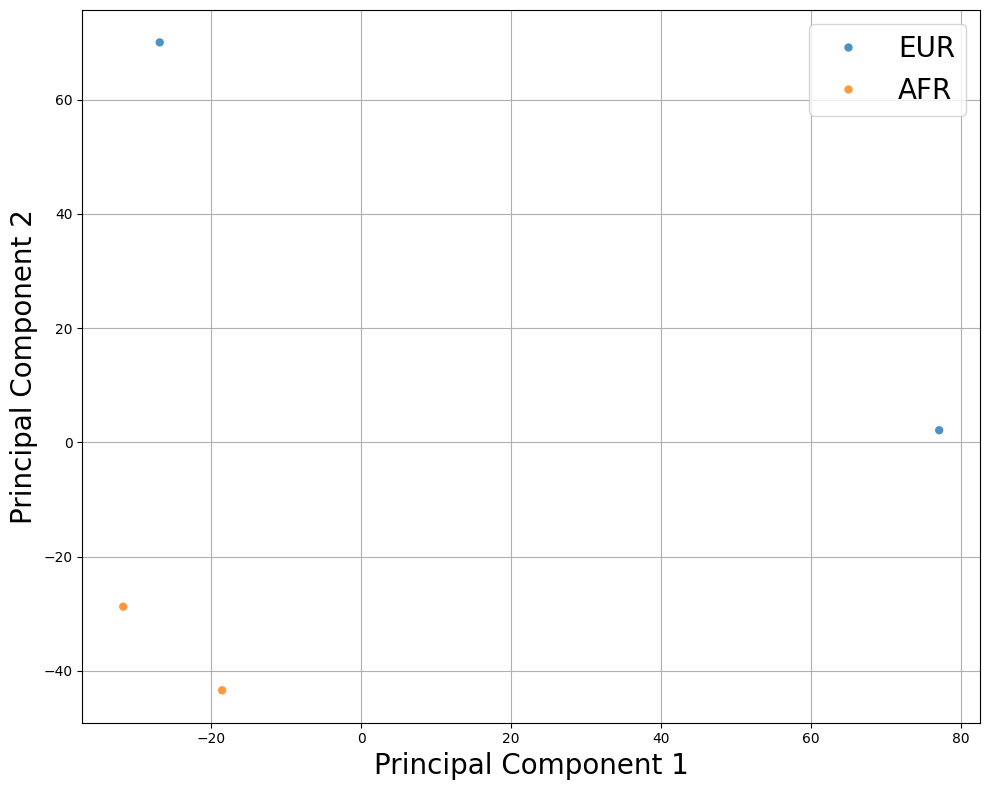

In [6]:
# Create DataFrame for plotting with PCA components and labels
df = pd.DataFrame({
    "Principal Component 1": components[:, 0],
    "Principal Component 2": components[:, 1],
    "Label": labels
})
print("DataFrame for visualization:\n", df.head())

# Plot the PCA results with seaborn scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x="Principal Component 1", y="Principal Component 2", hue="Label", linewidth=0, alpha=0.8)
plt.grid()
plt.legend(fontsize=20)
plt.xlabel("Principal Component 1", fontsize=20)
plt.ylabel("Principal Component 2", fontsize=20)
plt.tight_layout()
plt.show()